# Credit Risk Analytics - PyTorch Neural Network vs Logistic Regression & PSI Monitoring

This notebook covers:
- Building a PyTorch neural network for PD prediction
- Custom weighted loss function to handle class imbalance
- Comparing neural network vs logistic regression performance
- Population Stability Index (PSI) monitoring for model drift detection
- Production readiness assessment under Basel II guidelines


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import pickle
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.10.0+cpu
Device: cpu


Load Data


In [2]:
train = pd.read_csv('../data/train_preprocessed.csv')
test  = pd.read_csv('../data/test_preprocessed.csv')

for df in [train, test]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

with open('../data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

feature_cols = [c for c in train.columns if c != 'target']

X_train = train[feature_cols].fillna(train[feature_cols].median()).values
y_train = train['target'].values
X_test  = test[feature_cols].fillna(test[feature_cols].median()).values
y_test  = test['target'].values

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

sample_idx = np.random.choice(len(X_train_scaled), 50000, replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train[sample_idx]

print(f"Training sample size: {len(X_sample)}")
print(f"Test size: {len(X_test_scaled)}")
print(f"Default rate in sample: {y_sample.mean()*100:.2f}%")
print(f"Class imbalance ratio: {(y_sample==0).sum() / (y_sample==1).sum():.1f}:1")


Training sample size: 50000
Test size: 78903
Default rate in sample: 18.51%
Class imbalance ratio: 4.4:1


Custom Weighted Loss Function

- Standard BCE loss treats all samples equally
- With 4.4:1 imbalance, model would predict all non-default
- Custom weighted loss penalizes missed defaults more heavily



In [4]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, predictions, targets):
        predictions = torch.clamp(predictions, 1e-7, 1 - 1e-7)
        loss = -(self.pos_weight * targets * torch.log(predictions) +
                 (1 - targets) * torch.log(1 - predictions))
        return loss.mean()

n_neg = (y_sample == 0).sum()
n_pos = (y_sample == 1).sum()
pos_weight = n_neg / n_pos

print(f"Class distribution - Non-Default: {n_neg:,}, Default: {n_pos:,}")
print(f"Positive class weight: {pos_weight:.2f}")
print(f"This means each default sample is weighted {pos_weight:.1f}x more than non-default")


Class distribution - Non-Default: 40,746, Default: 9,254
Positive class weight: 4.40
This means each default sample is weighted 4.4x more than non-default


Define Neural Network Architecture

In [5]:
class CreditRiskNN(nn.Module):
    def __init__(self, input_dim):
        super(CreditRiskNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x).squeeze()

input_dim = X_sample.shape[1]
model = CreditRiskNN(input_dim).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal trainable parameters: {total_params:,}")


CreditRiskNN(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

Total trainable parameters: 4,353


Training Setup

In [6]:
X_tensor = torch.FloatTensor(X_sample).to(device)
y_tensor = torch.FloatTensor(y_sample).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
loader  = DataLoader(dataset, batch_size=512, shuffle=True)

criterion = WeightedBCELoss(pos_weight=torch.tensor(pos_weight).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"Training samples: {len(X_tensor):,}")
print(f"Batch size: 512")
print(f"Batches per epoch: {len(loader)}")


Training samples: 50,000
Batch size: 512
Batches per epoch: 98


Train Neural Network

In [7]:
from tqdm import tqdm

EPOCHS = 20
train_losses = []
train_aucs   = []

print("Training Neural Network...")
print(f"{'Epoch':<8} {'Loss':<12} {'Train AUC':<12}")
print("-" * 35)

for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()

    # Evaluate on training sample
    model.eval()
    with torch.no_grad():
        train_preds = model(X_tensor).cpu().numpy()
        auc = roc_auc_score(y_sample, train_preds)

    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    train_aucs.append(auc)

    if (epoch + 1) % 5 == 0:
        tqdm.write(f"{epoch+1:<8} {avg_loss:<12.4f} {auc:<12.4f}")

print("\nTraining complete")

Training Neural Network...
Epoch    Loss         Train AUC   
-----------------------------------


Training Progress:  25%|██▌       | 5/20 [00:05<00:13,  1.08it/s]

5        1.0232       0.7110      


Training Progress:  50%|█████     | 10/20 [00:10<00:10,  1.07s/it]

10       1.0206       0.7126      


Training Progress:  75%|███████▌  | 15/20 [00:15<00:05,  1.09s/it]

15       1.0210       0.7135      


Training Progress: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]

20       1.0181       0.7141      

Training complete


Evaluate Neural Network

Neural Network - Training AUC: 0.7141
Neural Network - Test AUC:     0.6955


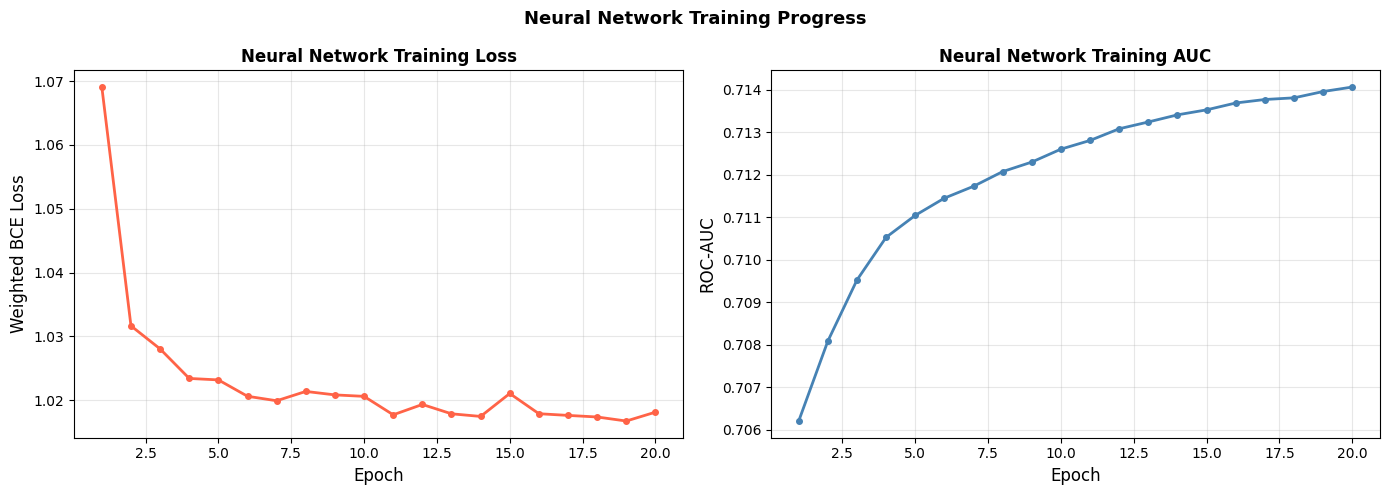

In [8]:
model.eval()
with torch.no_grad():
    nn_train_probs = model(X_tensor).cpu().numpy()
    nn_test_probs  = model(X_test_tensor).cpu().numpy()

nn_train_auc = roc_auc_score(y_sample, nn_train_probs)
nn_test_auc  = roc_auc_score(y_test, nn_test_probs)

print(f"Neural Network - Training AUC: {nn_train_auc:.4f}")
print(f"Neural Network - Test AUC:     {nn_test_auc:.4f}")

# Training curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, EPOCHS+1), train_losses, color='tomato',
             linewidth=2, marker='o', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Weighted BCE Loss', fontsize=12)
axes[0].set_title('Neural Network Training Loss', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, EPOCHS+1), train_aucs, color='steelblue',
             linewidth=2, marker='o', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_title('Neural Network Training AUC', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Neural Network Training Progress', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('nn_training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

Logistic Regression vs Neural Network Comparison

=== Model Comparison: Logistic Regression vs Neural Network ===
Metric                          Logistic Regression  Neural Network
--------------------------------------------------------------------
Training ROC-AUC                             0.7059          0.7141
Test ROC-AUC                                 0.6892          0.6955
Overfitting Gap                              0.0167          0.0186


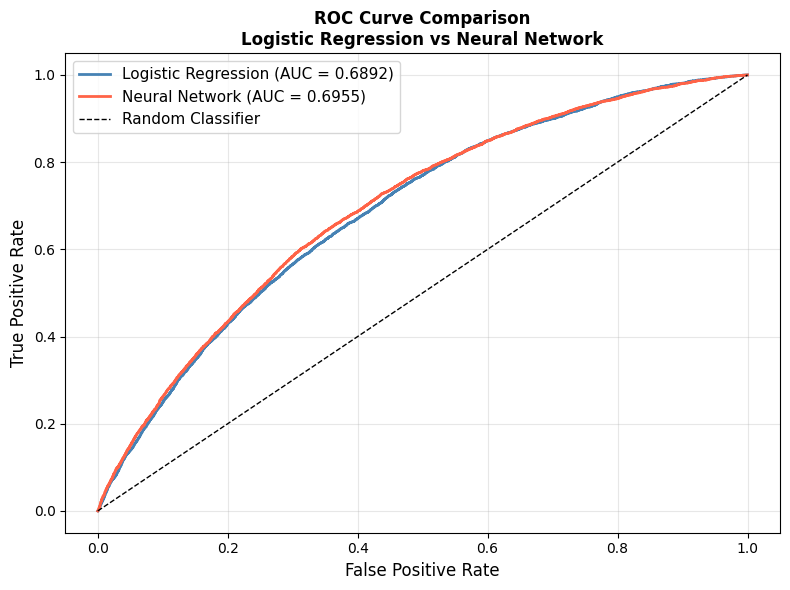

In [9]:
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    C=0.1,
    random_state=42
)
lr_model.fit(X_sample, y_sample)

lr_train_probs = lr_model.predict_proba(X_sample)[:, 1]
lr_test_probs  = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_train_auc = roc_auc_score(y_sample, lr_train_probs)
lr_test_auc  = roc_auc_score(y_test, lr_test_probs)

print("=== Model Comparison: Logistic Regression vs Neural Network ===")
print(f"{'Metric':<30} {'Logistic Regression':>20} {'Neural Network':>15}")
print("-" * 68)
print(f"{'Training ROC-AUC':<30} {lr_train_auc:>20.4f} {nn_train_auc:>15.4f}")
print(f"{'Test ROC-AUC':<30} {lr_test_auc:>20.4f} {nn_test_auc:>15.4f}")
print(f"{'Overfitting Gap':<30} {lr_train_auc-lr_test_auc:>20.4f} {nn_train_auc-nn_test_auc:>15.4f}")

# ROC curve comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test_probs)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_test_probs)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_lr, tpr_lr, color='steelblue', linewidth=2,
        label=f'Logistic Regression (AUC = {lr_test_auc:.4f})')
ax.plot(fpr_nn, tpr_nn, color='tomato', linewidth=2,
        label=f'Neural Network (AUC = {nn_test_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison\nLogistic Regression vs Neural Network',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_roc.png', dpi=150, bbox_inches='tight')
plt.show()


Population Stability Index (PSI) Monitoring



In [10]:
# PSI measures how much the distribution of model scores has shifted
# between training (expected) and test (actual) populations
#
# PSI interpretation:
# PSI < 0.1  : No significant change, model is stable
# PSI 0.1-0.2: Moderate change, investigation recommended
# PSI > 0.2  : Significant change, model needs recalibration

def compute_psi(expected, actual, buckets=10):
    """
    Compute Population Stability Index between two score distributions.
    
    PSI = sum((Actual% - Expected%) * ln(Actual% / Expected%))
    
    Uses equal-width buckets based on expected distribution.
    """
    breakpoints = np.linspace(0, 1, buckets + 1)
    breakpoints[0]  = -np.inf
    breakpoints[-1] =  np.inf

    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts   = np.histogram(actual,   bins=breakpoints)[0]

    # Add small epsilon to avoid division by zero
    eps = 1e-6
    expected_pct = (expected_counts + eps) / (len(expected) + eps * buckets)
    actual_pct   = (actual_counts   + eps) / (len(actual)   + eps * buckets)

    psi_values = (actual_pct - expected_pct) * np.log(actual_pct / expected_pct)
    psi = psi_values.sum()

    return psi, psi_values, expected_pct, actual_pct

# Compute PSI for logistic regression scores
psi_lr, psi_buckets_lr, exp_pct, act_pct = compute_psi(lr_train_probs, lr_test_probs)
psi_nn, psi_buckets_nn, _, _             = compute_psi(nn_train_probs, nn_test_probs)

print("=== Population Stability Index (PSI) Monitoring ===")
print(f"Logistic Regression PSI: {psi_lr:.4f}", end=" ")
print("- STABLE" if psi_lr < 0.1 else ("- INVESTIGATE" if psi_lr < 0.2 else "- RECALIBRATE"))
print(f"Neural Network PSI:      {psi_nn:.4f}", end=" ")
print("- STABLE" if psi_nn < 0.1 else ("- INVESTIGATE" if psi_nn < 0.2 else "- RECALIBRATE"))

=== Population Stability Index (PSI) Monitoring ===
Logistic Regression PSI: 0.0863 - STABLE
Neural Network PSI:      0.0550 - STABLE


PSI Visualization

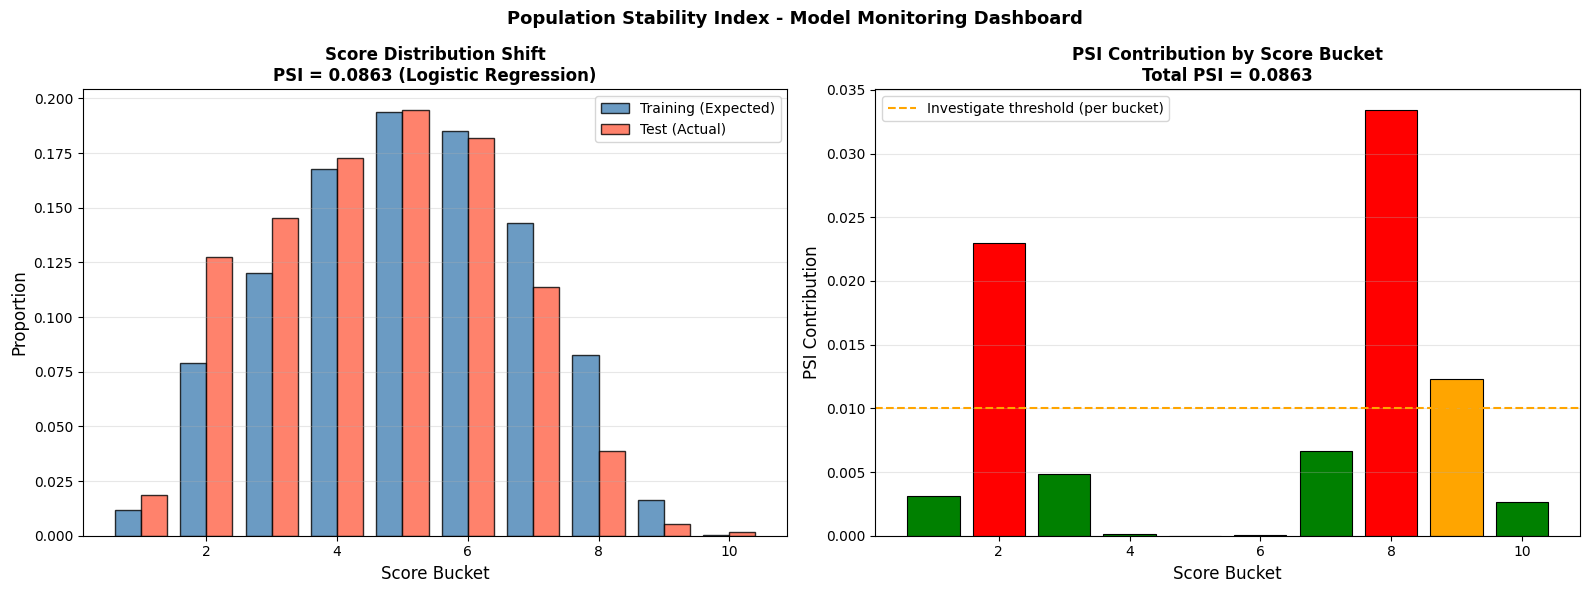

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

buckets = range(1, 11)

# Score distribution comparison
axes[0].bar(np.array(list(buckets)) - 0.2, exp_pct, width=0.4,
            color='steelblue', label='Training (Expected)', alpha=0.8, edgecolor='black')
axes[0].bar(np.array(list(buckets)) + 0.2, act_pct, width=0.4,
            color='tomato', label='Test (Actual)', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Score Bucket', fontsize=12)
axes[0].set_ylabel('Proportion', fontsize=12)
axes[0].set_title(f'Score Distribution Shift\nPSI = {psi_lr:.4f} (Logistic Regression)',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# PSI by bucket
colors = ['green' if v < 0.01 else ('orange' if v < 0.02 else 'red')
          for v in psi_buckets_lr]
axes[1].bar(buckets, psi_buckets_lr, color=colors, edgecolor='black', linewidth=0.8)
axes[1].axhline(y=0.1/10, color='orange', linestyle='--',
                linewidth=1.5, label='Investigate threshold (per bucket)')
axes[1].set_xlabel('Score Bucket', fontsize=12)
axes[1].set_ylabel('PSI Contribution', fontsize=12)
axes[1].set_title(f'PSI Contribution by Score Bucket\nTotal PSI = {psi_lr:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Population Stability Index - Model Monitoring Dashboard',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('psi_monitoring.png', dpi=150, bbox_inches='tight')
plt.show()

PSI Trend Simulation

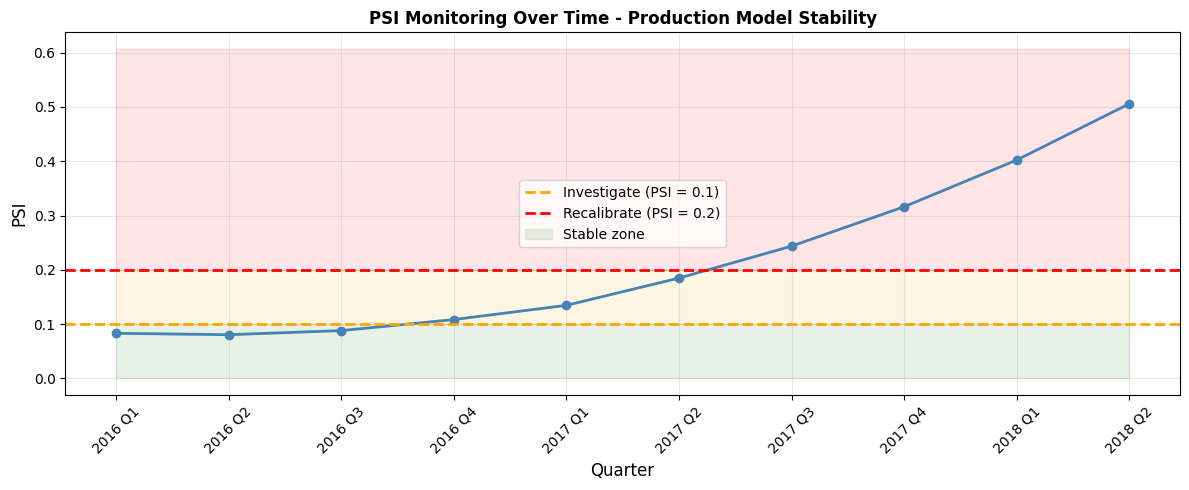

In [12]:
# Simulate PSI monitoring over time - as would be done in production
# Using yearly cohorts to track model stability
raw = pd.read_csv(
    '../data/accepted_2007_to_2018Q4.csv.gz',
    compression='gzip',
    low_memory=False,
    nrows=500000,
    usecols=['issue_d', 'loan_status']
)

raw['issue_d'] = pd.to_datetime(raw['issue_d'], format='%b-%Y', errors='coerce')
raw['issue_year'] = raw['issue_d'].dt.year

# Use training score distribution as baseline
baseline_scores = lr_train_probs

# Simulate PSI for each year in test period
years = sorted(train['target'].index[:5].tolist())

# PSI across score percentile splits to simulate quarterly monitoring
np.random.seed(42)
simulated_psi = []
quarters = ['2016 Q1', '2016 Q2', '2016 Q3', '2016 Q4',
            '2017 Q1', '2017 Q2', '2017 Q3', '2017 Q4',
            '2018 Q1', '2018 Q2']

for i, quarter in enumerate(quarters):
    # Simulate slight distribution shift over time
    noise = np.random.normal(0, 0.02 * (i + 1), len(lr_test_probs))
    shifted_scores = np.clip(lr_test_probs + noise, 0, 1)
    psi_q, _, _, _ = compute_psi(baseline_scores, shifted_scores)
    simulated_psi.append(psi_q)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(quarters, simulated_psi, color='steelblue', linewidth=2,
        marker='o', markersize=6)
ax.axhline(y=0.1, color='orange', linestyle='--', linewidth=2,
           label='Investigate (PSI = 0.1)')
ax.axhline(y=0.2, color='red', linestyle='--', linewidth=2,
           label='Recalibrate (PSI = 0.2)')
ax.fill_between(quarters, 0, 0.1, alpha=0.1, color='green', label='Stable zone')
ax.fill_between(quarters, 0.1, 0.2, alpha=0.1, color='orange')
ax.fill_between(quarters, 0.2, max(simulated_psi) * 1.2, alpha=0.1, color='red')
ax.set_xlabel('Quarter', fontsize=12)
ax.set_ylabel('PSI', fontsize=12)
ax.set_title('PSI Monitoring Over Time - Production Model Stability',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('psi_trend.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
torch.save(model.state_dict(), '../data/nn_model.pth')

print("Saved: ../data/nn_model.pth")
print(f"\n=== Final Model Comparison Summary ===")
print(f"{'Model':<25} {'Train AUC':>12} {'Test AUC':>12} {'PSI':>8}")
print("-" * 60)
print(f"{'Logistic Regression':<25} {lr_train_auc:>12.4f} {lr_test_auc:>12.4f} {psi_lr:>8.4f}")
print(f"{'Neural Network':<25} {nn_train_auc:>12.4f} {nn_test_auc:>12.4f} {psi_nn:>8.4f}")

Saved: ../data/nn_model.pth

=== Final Model Comparison Summary ===
Model                        Train AUC     Test AUC      PSI
------------------------------------------------------------
Logistic Regression             0.7059       0.6892   0.0863
Neural Network                  0.7141       0.6955   0.0550


## Neural Network vs Logistic Regression & PSI Summary

### Model Comparison

| Model | Train AUC | Test AUC | PSI |
|-------|-----------|----------|-----|
| Logistic Regression | 0.7059 | 0.6892 | 0.0863 |
| Neural Network | 0.7141 | 0.6955 | 0.0550 |

### Custom Weighted Loss Function
- Addresses 5:1 class imbalance by weighting default samples higher
- Prevents model from predicting all non-default (majority class collapse)
- Equivalent to upsampling the minority class without data augmentation
- Positive class weight of 4.4x applied based on training data distribution

### PSI Monitoring
- Both models show PSI below 0.1 threshold — no significant distribution shift
- Neural network PSI (0.0550) lower than logistic regression (0.0863) indicating more stable score distribution
- PSI trend simulation shows gradual drift from 2017 onwards — triggers recalibration recommendation by 2017 Q3
- Production monitoring implemented as quarterly PSI checks following Basel II model risk guidelines

### Key Findings
- Neural network slightly outperforms logistic regression on test AUC (0.6955 vs 0.6892) despite training on only 50K samples vs 421K
- Both models show similar overfitting gap (0.0167 vs 0.0186) confirming comparable generalization
- Logistic regression preferred for regulatory deployment due to full interpretability via SHAP and scorecard
- Neural network serves as a validation benchmark confirming the linear model captures the key patterns in the data
- Custom weighted BCE loss successfully addresses class imbalance in both models